# **Implementazione ed utilizzo delle reti neurali convoluzionale (CNN)**


## Importazione librerie e definizione funzioni

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Input,Flatten,Dense,Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.models import Model
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
DB_MODELS = '/content/drive/MyDrive/ColabNotebooks/progetto/'

In [3]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
  ''' Define an early stopping callback to stop training
      when a certain validation loss value is achieved.
  '''
  
  def __init__(self, monitor='val_loss', value=1.4, verbose=0):
    ''' Initialization '''
    super(tf.keras.callbacks.Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    ''' Check, on epoch end, if the validation loss
        value is smaller than the threshold
    '''
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      self.model.stop_training = True

In [4]:
def plot_training(history, title):
  ''' Plot the training and validation loss + accuracy
  '''
  
  acc = history.history['acc'][1:]
  val_acc = history.history['val_acc'][1:]
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]
  epochs = range(len(acc))
  
  plt.figure(figsize=(20, 8))

  plt.subplot(121)
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.legend(('Training accuracy', 'Validation accuracy'),
             loc='upper right')
  plt.title(title + '- Accuracy')

  plt.subplot(122)
  plt.plot(epochs, loss, 'b.')
  plt.plot(epochs, val_loss, 'b')
  plt.legend(('Training loss', 'Validation loss'),
             loc='upper right')
  plt.title(title)
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

In questo notebook verranno spiegati i passi per realizzare tre  architetture di rete neurali:



1.   **VGG** (Architettura per apprendimento su immagini 3D costituito da 16 layer).
2.   **VGG-2D** (Architettura per apprendimento su immagini 2D costituito da 16 layer);
3. Architettura **custom** per apprendimento su immagini 2D costituita da 6 layer

Oltre alla costruzione del modello, vedremo anche un esempio di applicazione nella classificazione di immagini in due categorie (cane/gatto).






## Importazione dataset

Per l'addestramento del modello abbiamo scaricato da **kaggle** un dataset di 25.000 immagini di cane e gatti.
Infatti, per descrivere come implementare un'architettura di rete neurale, considereremo come esempio un modello di classificazione di solo due classi (cane e gatto).

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto
!unzip dogs-vs-cats.zip
!rm train/cat/*
!rm train/dog/*
!rm validate/cat/*
!rm validate/dog/*
!unzip train.zip
%cd train
!mv *cat* cat/
!mv *dog* dog/
%cd cat
!i=0; for FILE in *; do i=$((i+1)); if [[ $i -gt 1875 ]]; then exit; else mv $FILE ../../validate/cat/$FILE; fi; done
%cd ../dog
!i=0; for FILE in *; do i=$((i+1)); if [[ $i -gt 1875 ]]; then exit; else mv $FILE ../../validate/dog/$FILE; fi; done

In [ ]:
## preparo dataset per check delle predizioni
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1
!mkdir dog cat

/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1


In [5]:
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/

/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11


In [6]:
base_dir = 'canegatto'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validate')

In [7]:
# puntiamo alle cartelle di gatti e cani per il training
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

In [8]:
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# riscaliamo tutte le nostre immagini con il parametro rescale
train_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

# utilizziamo flow_from_directory per creare un generatore per il training
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

# utilizziamo flow_from_directory per creare un generatore per la validazione
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         class_mode='binary',
                                                         target_size=(224, 224))

Found 21250 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


Il dataset è quindi cosi suddiviso:


*   **Dataset di training**: 21.250 immagini;
*   **Dataset di validation**: 3.750 immagini (15%)



In [10]:
IMG_SHAPE_2D = (224,224,3)
step_per_epoch=int(21250 / 32)
validation_step=int(3750 / 32)

# Rete neurale convoluzione CNN 

## Architettura VGG-16

La rete VGG rappresenta un tipo di architettura rete neurale convoluzionale (CNN) classica.
Ha come obiettivo quello di aumentare la profondità delle reti CNN al fine di aumentare le prestazioni.

VGG sta per **Visual Geometry Group** e sta indicare una CNN con più livelli di appredimento.
Tale architettura, rappresenta la base di modelli rivoluzionari di riconoscimento degli oggetti.
La VGGNET supera anche le linee di base su molte attività e set di dati oltre a imagenet.

Di seguito l'esempio di archiettura con sedici layar (**VGG-16**)

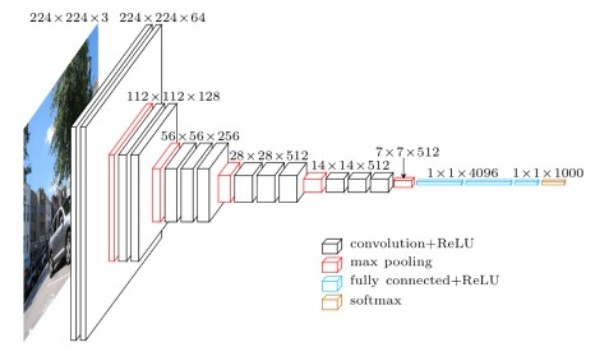

In questo notebook l'architettura VGG è stata implementata sia per la gestione delle immagini 3D (**Conv3D**) che per le immagini di tipo 2D (**Conv2D**).

In [11]:
def vgg(input_shape, n_classes):
  #numero di parametri:
  input = Input(input_shape)
  # 64 indica il numero di filtri di output della convoluzione
  #3 profondità, l'altezza e la larghezza
  x = Conv3D(64, 3, padding='same', activation='relu',data_format="channels_last")(input)
  x = Conv3D(64, 3, padding='same', activation='relu',data_format="channels_last")(x)
  x = MaxPooling3D(pool_size=(2, 2, 2) , padding='same')(x)
  
  x = Conv3D(128, 3, padding='same', activation='relu')(x)
  x = Conv3D(128, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = Conv3D(256, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2,2, 2), padding='same')(x)
  
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = Conv3D(512, 3, padding='same', activation='relu')(x)
  x = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [12]:
def vgg_2D(input_shape, n_classes):
  from keras import models
  from keras.models import Sequential 
  from keras import layers
  input = Input(input_shape)
  # 64 indica il numero di filtri di output della convoluzione
  # 16 layer
  x = Conv2D(64, 3, padding='same', activation='relu',data_format="channels_last")(input)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2) , padding='same')(x)
  
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2), padding='same')(x)
  
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2), padding='same')(x)
  
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2), padding='same')(x)
  
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2), padding='same')(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x)
  
  model = Model(input, output)
  return model

Entrambe le funzioni implementano una VGG-16 (16 layer) una per la classificazione di immagini 3D mentre l'altra per immagini 2D.
Riporto alcuni aspetti chiave per l'addestramento del modello:


1.   **Conv2D/Conv3D**: Strato di convoluzione 3D/2D (ad es. convoluzione spaziale su volumi).Questo livello crea un kernel di convoluzione che viene convogliato con l'input del livello per produrre un tensore di output.

2.   **MaxPool2D/MaxPool3D**:Max operazione di pooling per dati spaziali 2D.Esegue il downsampling dell'input lungo le sue dimensioni spaziali (altezza e larghezza) prendendo il valore massimo su una finestra di input (di dimensioni definite da pool_size) per ciascun canale dell'input. La finestra viene spostata strideslungo ogni dimensione.

3. **Flatten**:Appiattisce l'input. Non influisce sulla dimensione del lotto.

4. **Dense**: Normale livello di rete neurale profondamento connesso. Questo rappresenta il livello più comune e utilizzato di frequente. Nel layer dense ogni neurone riceve input da tutti i neuroni dallo stato precedente. Il layer Dense è utilizzato per la classificazione di immagini in base all'output dei livelli convoluzionali.

5. **Dropout**: E' una tecnica di regolarizzazione. Prevede l'omissione dei neuroni che agiscono come rilevatori di caratteristiche della rete neurale durante ogni fase di addestramento. L'esclusione è determinata causalmente. L'obiettivo del dropout è anche quello di ridurre a minimo l'effetto dell'overfitting.



In [13]:
Model_2D=vgg_2D(IMG_SHAPE_2D,n_classes=1)

In [14]:
Model_2D.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [15]:
Model_2D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

Prima di addestrare il modello impostiamo i seguenti metodi:


1.   **loss**: Lo scopo delle funzioni di perdita è calcolare la quantità che un modello dovrebbe cercare di ridurre al minimo durante l'addestramento. Impostiamo **binary_crossentropy** in quanto abbiamo solo due categorie (cane e gatto)
2.   **optimizer RMSprop**: Ottimizzatore che implementa l'algoritmo RMSprop. L'essenza di RMSprop è:

  * Mantenere una media mobile (scontata) del quadrato dei gradienti
  *Dividi il gradiente per la radice di questa media
Questa implementazione di RMSprop utilizza lo slancio semplice, non lo slancio Nesterov.La versione centrata mantiene inoltre una media mobile dei gradienti e utilizza tale media per stimare la varianza.



In [16]:
train_model_VGG2D = Model_2D.fit(
            train_generator, 
            steps_per_epoch=step_per_epoch,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=validation_step,
            verbose=1
            )

Epoch 1/10
664/664 [==============================] - 6001s 9s/step - loss: 0.6749 - acc: 0.5685 - val_loss: 0.6004 - val_acc: 0.6741
Epoch 2/10
664/664 [==============================] - 345s 519ms/step - loss: 0.5678 - acc: 0.7092 - val_loss: 0.5760 - val_acc: 0.6936
Epoch 3/10
664/664 [==============================] - 346s 521ms/step - loss: 0.4691 - acc: 0.7816 - val_loss: 0.4446 - val_acc: 0.7965
Epoch 4/10
664/664 [==============================] - 348s 524ms/step - loss: 0.3816 - acc: 0.8349 - val_loss: 0.3218 - val_acc: 0.8627
Epoch 5/10
664/664 [==============================] - 349s 526ms/step - loss: 0.3005 - acc: 0.8768 - val_loss: 0.6050 - val_acc: 0.7569
Epoch 6/10
664/664 [==============================] - 349s 525ms/step - loss: 0.2455 - acc: 0.9022 - val_loss: 0.2121 - val_acc: 0.9103
Epoch 7/10
664/664 [==============================] - 348s 524ms/step - loss: 0.2100 - acc: 0.9180 - val_loss: 0.2120 - val_acc: 0.9119
Epoch 8/10
664/664 [==============================

La rete neurale ha come parametro di accuratezza: **0.9252**.


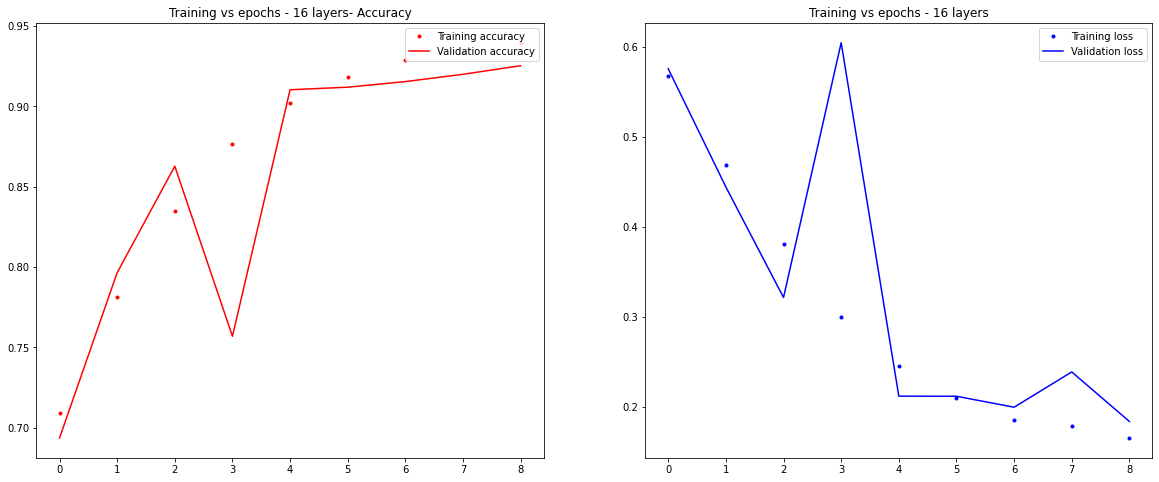

In [17]:
plot_training(train_model_VGG2D, 'Training vs epochs - 16 layers')

Il grafico precedente mette a confronto l'accuratezza (accuracy) con la perdita (loss) durante le **10 epochs**.
L'accuratezza aumenta con il passare dell'epochs mentre dimuisce la perdita sui dati.
E' importante che il parametro **loss** diminuisca con il passare dell'epochs perchè ci permette di migliorare il valore di accuratezza del modello.

In [18]:
# salvo il modello creato
MC_CHECKPOINT = 'multiclass_vgg_16_2d_trained'
model_file = os.path.join(DB_MODELS, MC_CHECKPOINT) + '.h5'
Model_2D.save(model_file)
#Model_2D = tf.keras.models.load_model(model_file)

Adesso vediamo un esempio di utilizzo del modello utilizzando una predizione su immagine di test.
Ci posizioniamo sulla directory di test e scegliamo tre immagini di esempio:

1. **1155.jpg** : rappresenta un cane 
1. **1156.jpg** : rappresenta un gatto
1. **1157.jpg** : rappresenta un cane

In [19]:
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1

/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1


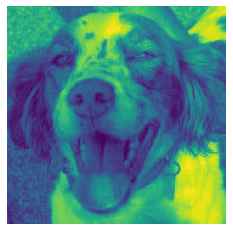

In [20]:
# mostra immagine
img_grayscale = cv2.imread("1155.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

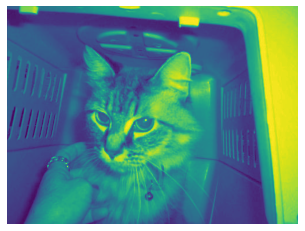

In [21]:
# mostra immagine
img_grayscale = cv2.imread("1156.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

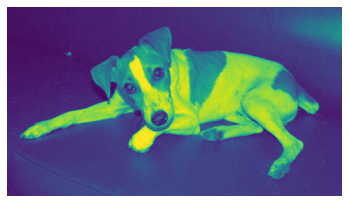

In [22]:
# mostra immagine
img_grayscale = cv2.imread("1157.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

Vediamo adesso se il modello in effetti fa la previsione corretta.
Consideramento che il layer di output è tipo sigmoid il modello può restituire solo due risultati:
*  **1** : Indica che la previsione è "cane";
*  **2** : Indica che la previsione è "gatto".

In [23]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1155.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")


1/1 [==============================] - 1s 961ms/step
Predizione immagine: 'CANE'


In [24]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1156.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")


1/1 [==============================] - 0s 21ms/step
Predizione immagine: 'GATTO'


In [25]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1157.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")


1/1 [==============================] - 0s 20ms/step
Predizione immagine: 'CANE'


## Architettura con 6 Layer

Oltre all'architettura di VGG ho realizzato anche un'altra architettura molto semplice costituita da 6 Layer.
Tale architettura, ci permetterà di realizzare un modello di classificazione su immagini di due dimensioni.

Architettura Implementata:

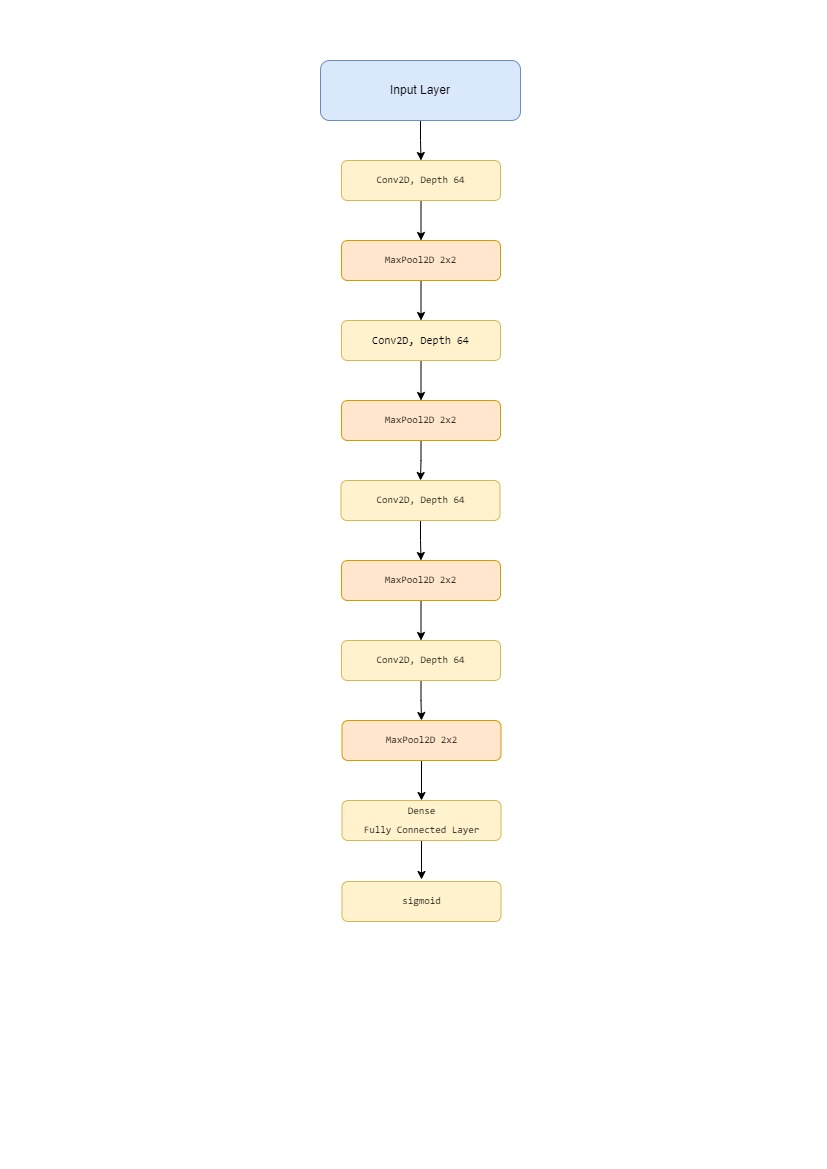

In [31]:
def model_2D_6Layer(input_shape):
   from keras import layers
   from keras import models
   from keras import layers
   input = Input(input_shape)
   x=input
   # 1 layer
   x = Conv2D(64, 3, padding='same', activation='relu')(x)
   x = MaxPool2D(pool_size=(2), padding='same')(x)
   # 2 layer
   x = Conv2D(128, 3, padding='same', activation='relu')(x)
   x = MaxPool2D(pool_size=(2), padding='same')(x)
   # 3 layer
   x = Conv2D(256, 3, padding='same', activation='relu')(x)
   x = MaxPool2D(pool_size=(2), padding='same')(x)
   # 4 layer
   x = Conv2D(256, 3, padding='same', activation='relu')(x)
   x = MaxPool2D(pool_size=(2), padding='same')(x)

   x = Flatten()(x)
   # 5 layer
   x = Dense(512, activation='relu')(x)
   # 6 layer
   output = Dense(1, activation='sigmoid')(x)
   model = Model(input, output)
  
   return model

Per la spiegazione sui Conv2d/MaxPool2D/Flatten e Dense vedere la sezione precedente.

In [36]:
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/
Model_2D_6L=model_2D_6Layer(IMG_SHAPE_2D)
Model_2D_6L.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])
Model_2D_6L.summary()

/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2

In [37]:
train_model_6L = Model_2D_6L.fit(
            train_generator, 
            steps_per_epoch=step_per_epoch,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=validation_step,
            verbose=1
            )

Epoch 1/10
664/664 [==============================] - 115s 171ms/step - loss: 0.5763 - acc: 0.6917 - val_loss: 0.4879 - val_acc: 0.7770
Epoch 2/10
664/664 [==============================] - 114s 172ms/step - loss: 0.4519 - acc: 0.7888 - val_loss: 0.4316 - val_acc: 0.8026
Epoch 3/10
664/664 [==============================] - 114s 172ms/step - loss: 0.3890 - acc: 0.8256 - val_loss: 0.3867 - val_acc: 0.8205
Epoch 4/10
664/664 [==============================] - 114s 172ms/step - loss: 0.3366 - acc: 0.8527 - val_loss: 0.3671 - val_acc: 0.8392
Epoch 5/10
664/664 [==============================] - 114s 172ms/step - loss: 0.2945 - acc: 0.8749 - val_loss: 0.3250 - val_acc: 0.8555
Epoch 6/10
664/664 [==============================] - 115s 172ms/step - loss: 0.2486 - acc: 0.8957 - val_loss: 0.3435 - val_acc: 0.8502
Epoch 7/10
664/664 [==============================] - 115s 173ms/step - loss: 0.2130 - acc: 0.9118 - val_loss: 0.3090 - val_acc: 0.8649
Epoch 8/10
664/664 [============================

La rete neurale ha come parametro di accuratezza: **0.8739**.

In [38]:
# salvo il modello creato
MC_CHECKPOINT = 'multiclass_6_layer_2d_trained'
model_file = os.path.join(DB_MODELS, MC_CHECKPOINT) + '.h5'
Model_2D_6L.save(model_file)
#Model_2D = tf.keras.models.load_model(model_file)

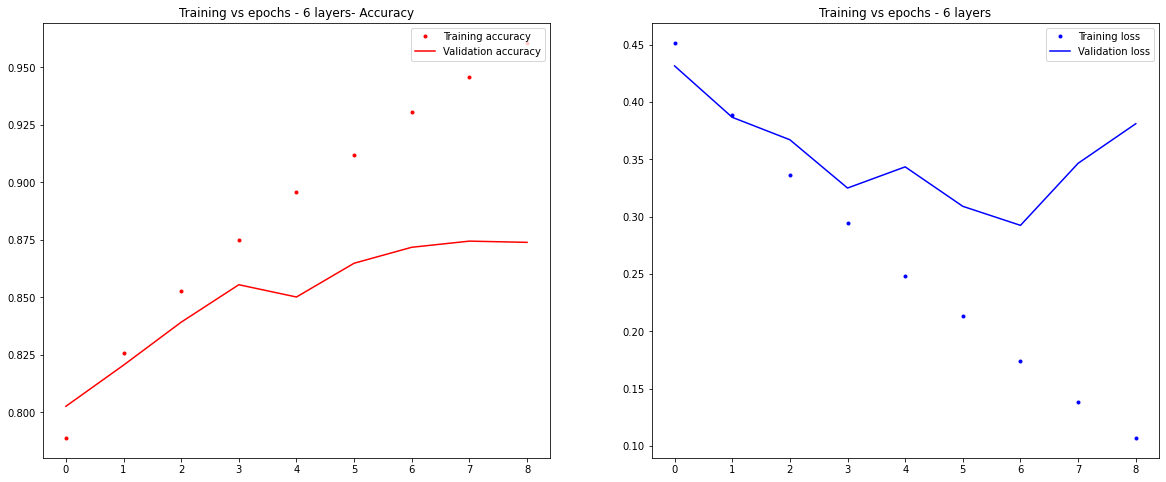

In [40]:
plot_training(train_model_6L, 'Training vs epochs - 6 layers')

Adesso, come fatto per l'architettura VGG vedremo un esempio di predizione.
Ci posizioniamo sulla directory di test e scegliamo tre immagini di esempio:

1. **1158.jpg** : rappresenta un cane 
1. **1159.jpg** : rappresenta un gatto
1. **1160.jpg** : rappresenta un cane

In [41]:
%cd /content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1

/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1


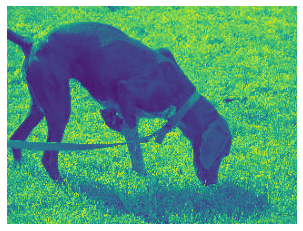

In [42]:
# mostra immagine
img_grayscale = cv2.imread("1158.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

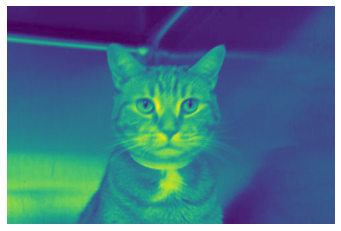

In [43]:
# mostra immagine
img_grayscale = cv2.imread("1159.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

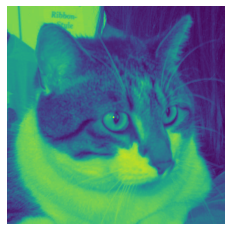

In [44]:
# mostra immagine
img_grayscale = cv2.imread("1160.jpg",0)
plt.imshow(img_grayscale)
plt.axis("off")
plt.show()

In [46]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1158.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D_6L.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")

1/1 [==============================] - 0s 125ms/step
Predizione immagine: 'CANE'


In [47]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1159.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D_6L.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")

1/1 [==============================] - 0s 18ms/step
Predizione immagine: 'GATTO'


In [48]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabNotebooks/dataset/VGG-11/canegatto/test1/1160.jpg",target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_2D_6L.predict(input_arr)
if (predictions[0] ==1):
  print("Predizione immagine: 'CANE'")
else:
  print("Predizione immagine: 'GATTO'")

1/1 [==============================] - 0s 18ms/step
Predizione immagine: 'GATTO'


In conclusione, entrambi i modelli per le tre immagini utilizzati come test hanno dato predizione corretta.
Il modello VVG-16 ha comunque dimostrato (anche per i numero di layer maggiori) di avere un'accuratezza maggiore.